---


1. Скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>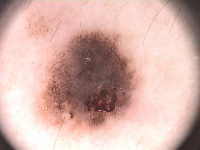</td><td>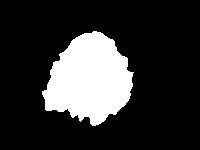</td></tr></table>

2. Разархивируем .rar файл.
3. Папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
Будем **сегментировать** их.

In [ ]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

In [ ]:
!ls

PH2Dataset.rar	sample_data


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

In [ ]:
images = []
lesions = []
names = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        dir = os.path.basename(os.path.normpath(root))
        names.append(dir[:6])
        print(root)
        print(names[-1])
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Изменяем их размер на $256\times256 $ пикселей.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

In [ ]:
X.shape, Y.shape

((200, 256, 256, 3), (200, 256, 256))

Чтобы убедиться, что все корректно, нарисуем несколько изображений

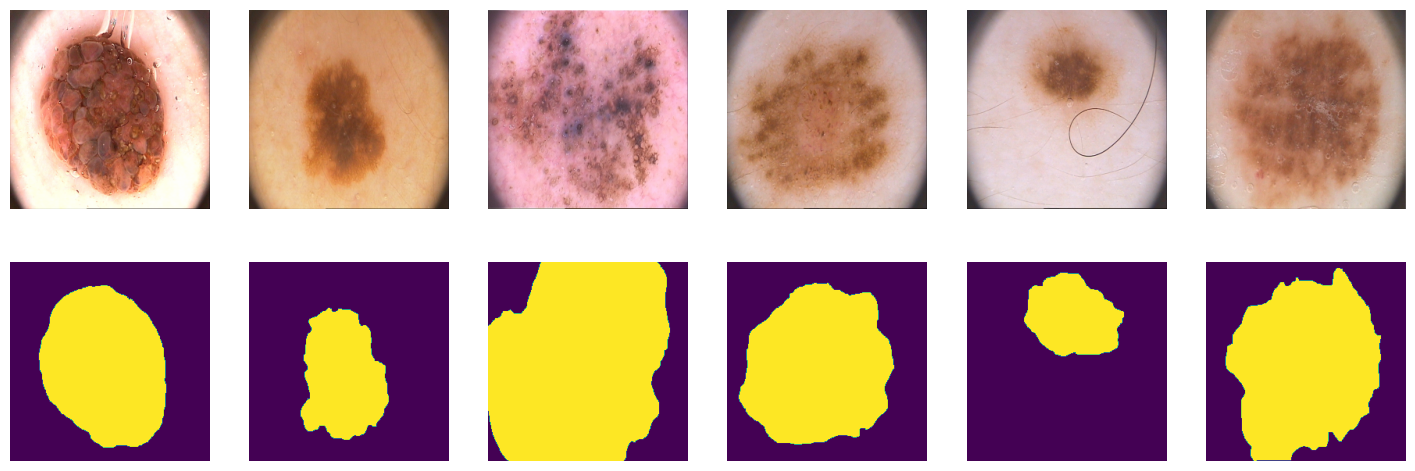

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Train/validation/test split:

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
!nvidia-smi

Tue Oct 24 00:55:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции.

#SegNet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15, 4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(inplace=True),
                                       )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv1 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(inplace=True),
                                       )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv2 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(inplace=True),
                                       )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv3 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(inplace=True),
                                       )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv4 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(inplace=True),
                                       )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv0 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(inplace=True),
                                       )
        self.upsample1 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv1 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(inplace=True),
                                       )
        self.upsample2 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv2 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(inplace=True),
                                       )
        self.upsample3 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(inplace=True),
                                       )
        self.upsample4 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv4 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
                                       )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))
        e4, ind4 = self.pool4(self.enc_conv4(e3))

        # decoder
        d0 = self.dec_conv0(self.upsample0(e4, ind4))
        d1 = self.dec_conv1(self.upsample1(d0, ind3))
        d2 = self.dec_conv2(self.upsample2(d1, ind2))
        d3 = self.dec_conv3(self.upsample3(d2, ind1))
        d4 = self.dec_conv4(self.upsample4(d3, ind0)) # no activation, no normalization, no softmax
        return d4

## Метрика


$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

## Лосс функция

In [ ]:
def bce_loss(y_pred, y_real):
    # TODO
    # don't use nn.BCELoss. write it from scratch
    return torch.mean(y_pred - torch.mul(y_real, y_pred) + torch.log(1 + torch.exp(-y_pred)))

In [ ]:
a1 = torch.tensor([1, 0, 1])
b1 = torch.tensor([1, 0, 1])
loss = torch.nn.BCEWithLogitsLoss()
print(loss(torch.tensor([1., 1., 1.]), torch.tensor([1., 1., 1.])))
torch.mean((bce_loss(torch.tensor([1., 1., 1.]), torch.tensor([1., 1., 1.]))))

tensor(0.3133)


tensor(0.3133)

## Тренировка

Определим цикл обучения в функции, чтобы повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_tr))
    scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for idx, (X_batch, Y_batch) in enumerate(data_tr):
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            if idx == 0:
                X_val = X_batch.clone().detach()
                Y_val = Y_batch.clone().detach()
                Y_out = torch.round(torch.sigmoid(Y_pred.clone().detach()))
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()  # backward-pass
            opt.step()  # update weights
            # calculate loss to show the user
            avg_loss += loss.item() / len(data_tr)

        # toc = time()
        train_losses.append(avg_loss)
        val_loss = 0
        model.eval()  # testing mode
        score = 0
        for X_batch, Y_label in data_val:
            Y_pred = model(X_batch.to(device))
            val_loss += loss_fn(Y_pred, Y_label.to(device)).item() / len(data_val)

        val_losses.append(val_loss)
        print('train_loss: %f, val_loss: %f' % (avg_loss, val_loss))
        scheduler.step()

        # show intermediate results
        X_val = X_val.cpu()
        Y_val = Y_val.cpu()
        Y_out = Y_out.cpu()

        visualize(X_val, Y_val, Y_out, epoch, epochs, avg_loss)

    return train_losses, val_losses

In [ ]:
def visualize(X_val, Y_val, Y_out, epoch, epochs, avg_loss):
    clear_output(wait=True)
    plt.figure(figsize=(18, 9))
    for k in range(6):
        plt.subplot(3, 6, k+1)
        plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3))
        plt.title('Real')
        plt.axis('off')

        plt.subplot(3, 6, k+7)
        plt.imshow(Y_val[k, 0])
        plt.title('Real segmentation')
        plt.axis('off')

        plt.subplot(3, 6, k+13)
        plt.imshow(Y_out[k, 0])
        plt.title('Output')
        plt.axis('off')
    plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
    plt.show()

## Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = torch.round(torch.sigmoid(model(data)))
    return Y_pred

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    score = 0
    for X_batch, Y_label in data:
        Y_pred = predict(model, X_batch.to(device))
        score += metric(Y_pred, Y_label.to(device)).mean().item() / len(data)

    return score

## Основной момент: обучение

Обучаем модель, подбираем параметры, проверяем сходимость.


In [ ]:
model = SegNet().to(device)

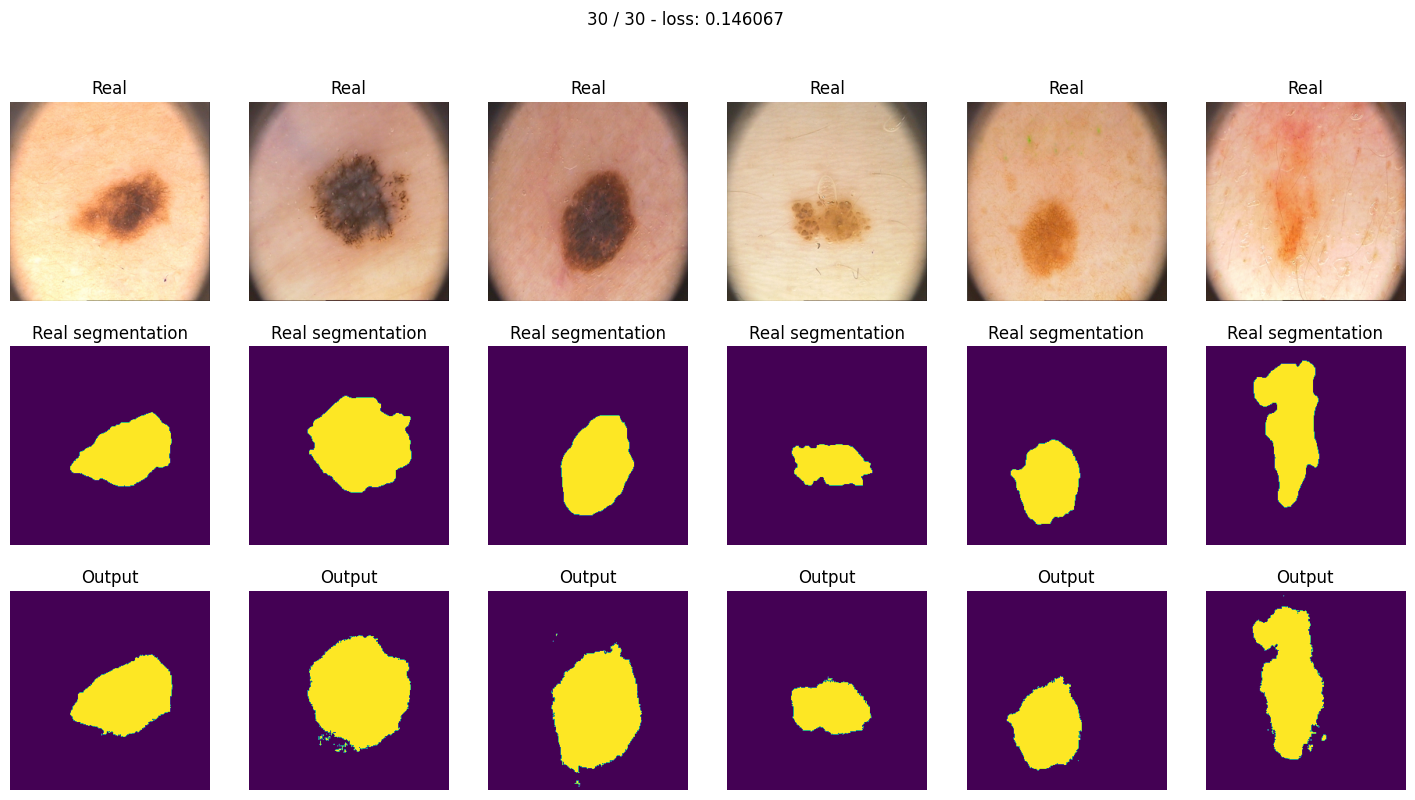

In [ ]:
max_epochs = 30
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
train_losses, val_losses = train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
import torch.optim

In [ ]:
score = score_model(model, iou_pytorch, data_val)
score

0.6880000114440918

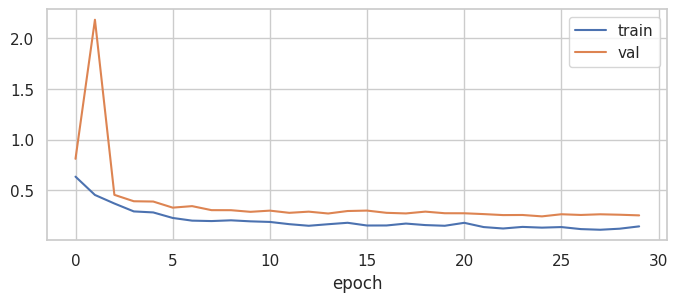

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1)

# Построим график лосса при обучении и валидации
plt.figure(figsize=(8, 3))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
def dice_loss(y_pred, y_real):
    # print(y_pred.shape)
    # print(y_real.shape)
    y_pred = y_pred.squeeze(1)
    y_real = y_real.squeeze(1)
    y_pred = (torch.sigmoid(y_pred))
    SMOOTH = 1e-12
    num = (2 * y_real * y_pred).sum((1, 2)) + SMOOTH
    # print(num.shape)
    den =  (y_real + y_pred).sum((1, 2)) + SMOOTH
    # print(den.shape)
    res = (1 - num / den).mean()
    # print(res)
    return res

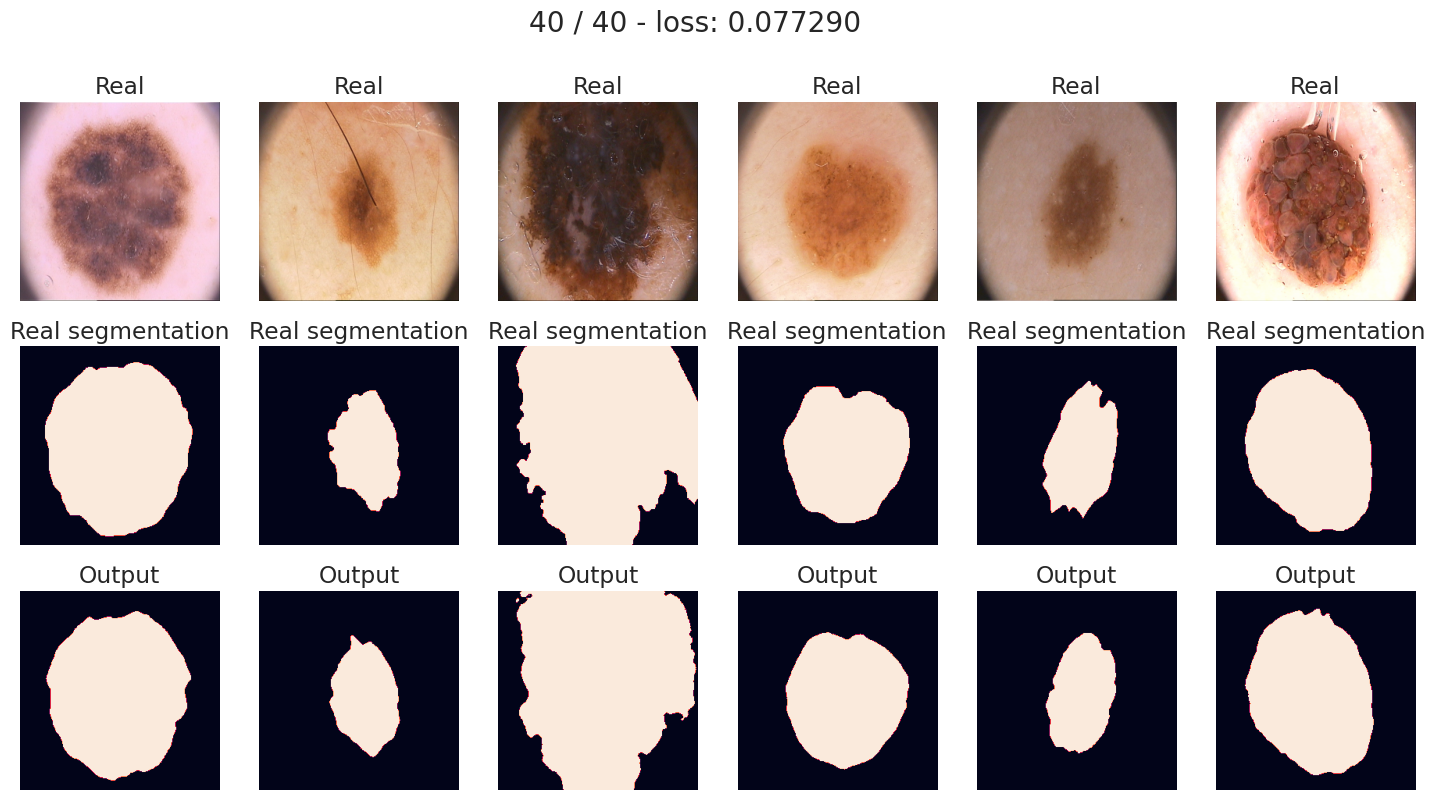

([0.6003907918930055,
  0.43995368182659145,
  0.3212945803999901,
  0.255499130487442,
  0.20746720507740973,
  0.17783503755927085,
  0.15287697687745094,
  0.1544074811041355,
  0.1487110920250416,
  0.13001224920153617,
  0.1270428724586964,
  0.12221506237983702,
  0.10964834839105607,
  0.10821023583412172,
  0.11065942347049713,
  0.109174183011055,
  0.11190057694911956,
  0.10692381300032139,
  0.1188969634473324,
  0.10321389473974703,
  0.08758945725858212,
  0.08690803423523902,
  0.08632856160402298,
  0.09641884155571459,
  0.09154104962944984,
  0.09690924435853956,
  0.08888742960989475,
  0.09101965799927714,
  0.07404665052890778,
  0.0828434009104967,
  0.08046050854027272,
  0.07794842422008515,
  0.0796066552400589,
  0.07619820125401021,
  0.08436537310481071,
  0.07482122704386711,
  0.07858600839972496,
  0.07289653271436691,
  0.08376699537038804,
  0.07729037925601005],
 [0.6067235469818115,
  0.5357917904853821,
  0.3884789288043976,
  0.22247716337442397,
  

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 40
optimizer = torch.optim.Adam(model_dice.parameters())
train(model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

0.7240000367164612

In [ ]:
# save model
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=False)

PATH = '/content/gdrive/My Drive/data/segnet_sgm.pth'
torch.save(model.state_dict(), PATH)

Mounted at /content/gdrive/


### Try segmentation on web images:

In [ ]:
# load images
from google.colab import drive
drive.mount('/content/drive')
from skimage.io import imread
import os
images = []
root = '/content/drive/MyDrive/'

for root, dirs, files in os.walk(os.path.join(root, 'data/skin_lesions')):
    for f in files:
        images.append(imread(os.path.join(root, f)))

Mounted at /content/drive


In [ ]:
# resize images and convert to numpy
import numpy as np
from skimage.transform import resize
size = (256, 256)
X = resize(x, size, mode='constant', anti_aliasing=True) for x in images
X = np.array(X, np.float32)
X.shape

(8, 256, 256, 3)

In [ ]:
# prediction
import torch
from torch.utils.data import DataLoader
batch_size = 10
data_real = DataLoader(list(np.rollaxis(X, 3, 1)), batch_size=batch_size, shuffle=False)

model_dice.eval()  # testing mode
X_batch = next(iter(data_real)).to(device)
Y = torch.round(torch.sigmoid(model_dice(X_batch)))
Y = Y.detach().cpu().numpy()
Y = np.rollaxis(Y, 1, 4)
Y.shape

(8, 256, 256, 1)

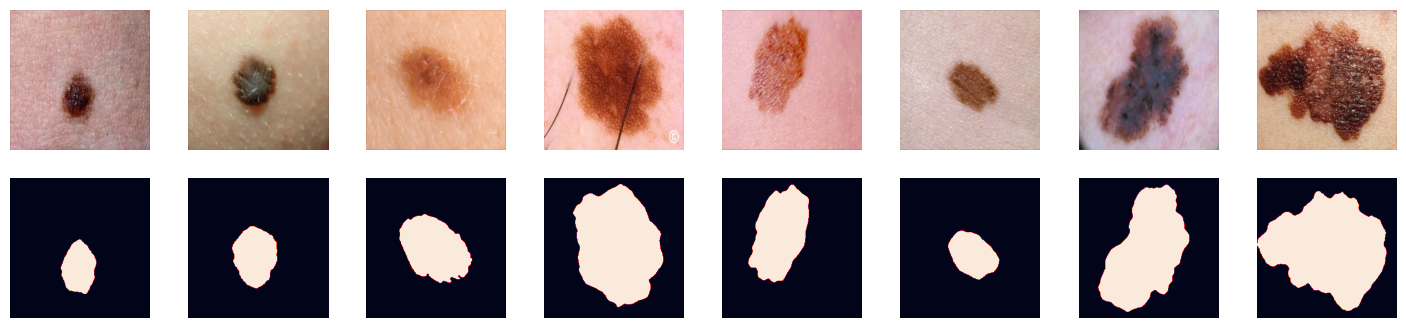

In [ ]:
# visualization
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 4))
for i in range(8):
    plt.subplot(2, 8, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 8, i+9)
    plt.axis("off")
    plt.imshow(Y[i])

plt.show();